# 🌱🌟 Recognizing Soys and Pods! 🌱
#### Softteliê Team 🤠

Reseting environment

In [ ]:
!rm -rf trainData/
!rm -rf sample_data/

Downloading TrainData

In [ ]:
!unzip -q trainData.zip # -q (quietly)

Downloading COCO Weights

In [ ]:
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

Downloading dependencies

In [ ]:
# !pip uninstall keras -y
# !pip uninstall keras-nightly -y
# !pip uninstall keras-Preprocessing -y
# !pip uninstall keras-vis -y
# !pip uninstall h5py -y
# !pip uninstall tensorflow -y

# !pip uninstall mrcnn -y

!pip install mrcnn
!pip install tensorflow==1.13.1
!pip install keras==2.2.5
!pip install h5py==2.10.0

!pip install matplotlib
!pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing necessary libs

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from numpy import expand_dims
from numpy import mean
from xml.etree import ElementTree
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
import imgaug.augmenters as iaa

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Cloning the R-CNN Library (manual installation)

In [ ]:
#!git clone https://github.com/matterport/Mask_RCNN.git

In [ ]:
#lib_folder = os.path.join(os.getcwd(), 'Mask_RCNN')

In [ ]:
#%cd {lib_folder}
#!python3 setup.py install
#%cd ..

Confirming installation

In [ ]:
#!pip show mask-rcnn

# Methods/classes to interact with the model

In [ ]:
# Original tutorial: https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

class SoyDataset(Dataset):
    
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("trainData", 1, "soy")
        self.add_class("trainData", 2, "pod")
        
        images_dir = dataset_dir + "/images/"
        annotations_dir = dataset_dir + "/annotations/"

        filenames = os.listdir(images_dir)
        files_quantity = len(filenames)
        dataset_size = round(files_quantity * 0.8)

        for i in range(files_quantity - 1):
            filename = filenames[i]
            image_id = i
            
            if is_train and image_id >= dataset_size:
                continue
            if not is_train and image_id < dataset_size:
                continue
                
            image_path = images_dir + filename
            annotation_path = annotations_dir + filename[:-4] + '.xml'
            
            self.add_image('trainData', image_id = image_id, path = image_path, annotation = annotation_path)
            i += 1

    def extract_boxes(self, filename):
        tree = ElementTree.parse(filename)
        root = tree.getroot()
        
        boxes = list()
        
        for labeledObject in root.findall('.//object'):
            name = labeledObject.find('name').text

            for box in labeledObject.findall('.//bndbox'):
                xmin = int(box.find('xmin').text)
                ymin = int(box.find('ymin').text)
                xmax = int(box.find('xmax').text)
                ymax = int(box.find('ymax').text)
                coordinates = [xmin, ymin, xmax, ymax, name]
                if name=='soy' or name=='pod':
                    boxes.append(coordinates)
            
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        return boxes, width, height
        
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        
        boxes, width, height = self.extract_boxes(path)
        masks = np.zeros([height, width, len(boxes)], dtype='uint8')
        
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]

            if (box[4] == 'soy'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('soy'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('pod'))   
   
        return masks, np.asarray(class_ids, dtype='int32')
        
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [ ]:
class SoyConfig(Config):
	NAME = "ehSoja_cfg"
	NUM_CLASSES = 3 # background, soy and pod
	STEPS_PER_EPOCH = 10

In [ ]:
class SoyPredictionConfig(Config):
	NAME = "ehSoja_cfg"
	NUM_CLASSES = 3 # background, soy and pod
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [ ]:
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		scaled_image = mold_image(image, cfg)
		sample = expand_dims(scaled_image, 0)
		yhat = model.detect(sample, verbose=0)
		r = yhat[0]
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		APs.append(AP)

	mAP = mean(APs)
	return mAP

In [74]:
def plot_actual_vs_predicted(dataset, model, cfg, filename, n_images=2):
	for i in range(n_images):
		plt.subplots(figsize=(60, 60))
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)

		scaled_image = mold_image(image, cfg)
  
		sample = expand_dims(scaled_image, 0)

		yhat = model.detect(sample, verbose=0)[0]
		
		# plt.subplot(n_images, 2, i*2+1)
		plt.subplot(1, 2, 1)
		plt.imshow(image)
  
		plt.title('Actual')
		# plot masks
		# for j in range(mask.shape[2]):
		#	plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
   
		# get the context for drawing boxes
		plt.subplot(1, 2, 2)
		# plt.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		plt.imshow(image)
		plt.title('Predicted')
		ax = plt.gca()

		rectangles = []

		# plot each box
		i = 0
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			class_id = yhat['class_ids'][i]
			box_color = "green"
			if class_id == 1: 
				box_color = "red"
			elif class_id == 2:
				box_color = "blue"

			rect = Rectangle((x1, y1), width, height, fill=False, color=box_color, lw=4.0)
			rectangles.append(rect)
			i += 1
		
		# draw the box
		for rectangle in rectangles:
			ax.add_patch(rectangle)
		# show the figure
		plt.savefig("/content/results/" + str(i) + filename)
		plt.show()

## Train images quantity

In [ ]:
train_set = SoyDataset()
train_set.load_dataset('trainData', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 922


(1100, 1100, 3)
(1100, 1100, 17)


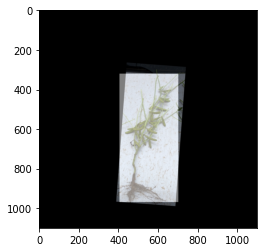

In [ ]:
train_set = SoyDataset()
train_set.load_dataset('trainData', is_train=True)
train_set.prepare()

image_id = 3
train_set.image_reference(image_id)

image = train_set.load_image(image_id=image_id)
print(image.shape)

mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

plt.imshow(image)

plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
plt.show()

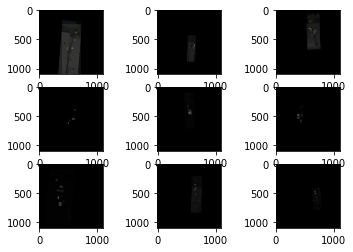

In [ ]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    image = train_set.load_image(i)
    plt.imshow(image)
    mask, _ = train_set.load_mask(i)

    for j in range(mask.shape[2]):
        plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)

plt.show()

In [ ]:
for image_id in train_set.image_ids:
	info = train_set.image_info[image_id]
	print(info)

{'id': 0, 'source': 'trainData', 'path': 'trainData/images/3eadd344-2089-44ad-ba93-c3186b6fcee1_2_aug1.jpg', 'annotation': 'trainData/annotations/3eadd344-2089-44ad-ba93-c3186b6fcee1_2_aug1.xml'}
{'id': 1, 'source': 'trainData', 'path': 'trainData/images/043a64ac-fa77-42c8-a8c0-3d9868a55716_1_aug1.jpg', 'annotation': 'trainData/annotations/043a64ac-fa77-42c8-a8c0-3d9868a55716_1_aug1.xml'}
{'id': 2, 'source': 'trainData', 'path': 'trainData/images/4fa8d033-43a9-4c46-bbc8-27a3c19710fe_1_aug6.jpg', 'annotation': 'trainData/annotations/4fa8d033-43a9-4c46-bbc8-27a3c19710fe_1_aug6.xml'}
{'id': 3, 'source': 'trainData', 'path': 'trainData/images/0b2bdc2d-4df2-4b86-a396-cb0325ea269b_2_aug2.jpg', 'annotation': 'trainData/annotations/0b2bdc2d-4df2-4b86-a396-cb0325ea269b_2_aug2.xml'}
{'id': 4, 'source': 'trainData', 'path': 'trainData/images/7d03d5e6-693e-47ef-ad03-2dbeee289aeb_1_aug7.jpg', 'annotation': 'trainData/annotations/7d03d5e6-693e-47ef-ad03-2dbeee289aeb_1_aug7.xml'}
{'id': 5, 'source': 

Train: 922
[1 2 2 2 2 2]


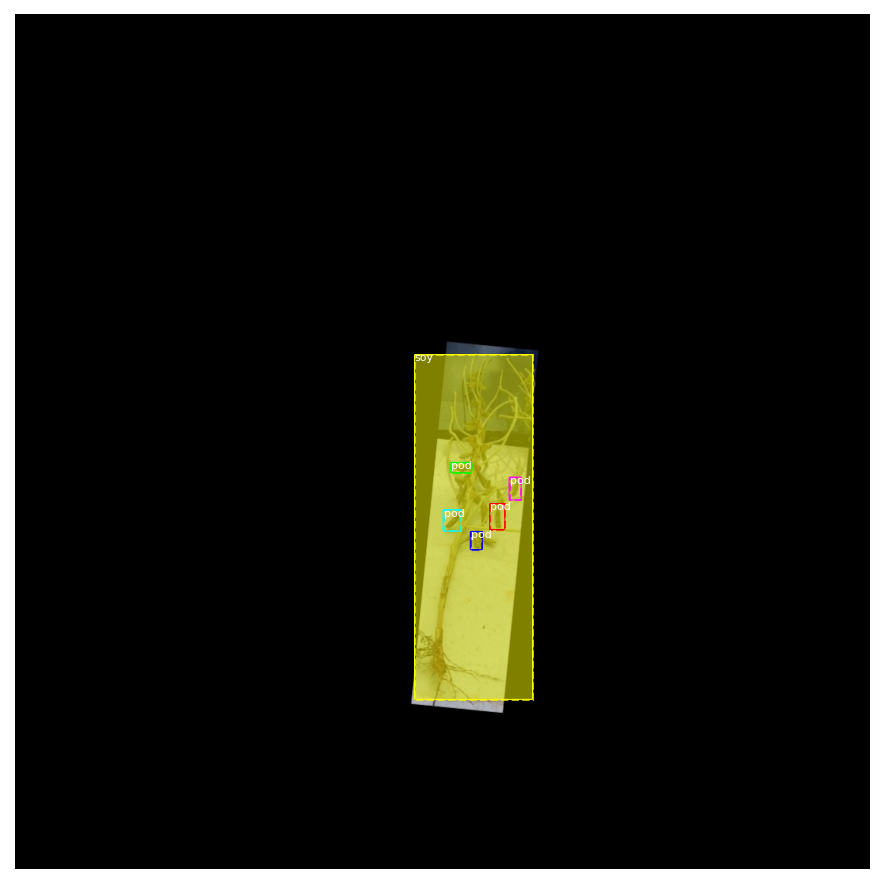

In [ ]:
train_set = SoyDataset()
train_set.load_dataset('trainData', is_train=True)
train_set.prepare()

print('Train: %d' % len(train_set.image_ids))

image_id = 1
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
print(class_ids)

bbox = extract_bboxes(mask)

display_instances(image, bbox, mask, class_ids, train_set.class_names)

## Test images quantity

Test: 229
[1 2 2 2 2 2 2 2 2 2 2 2]


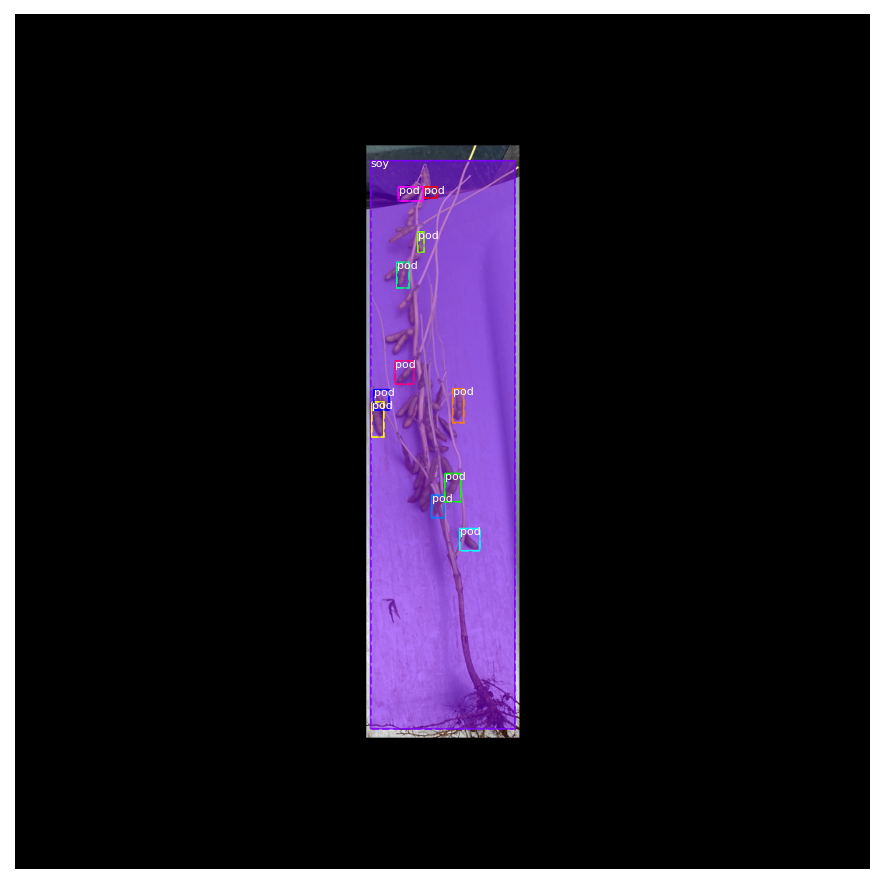

In [ ]:
test_set = SoyDataset()
test_set.load_dataset('trainData', is_train=False)
test_set.prepare()

print('Test: %d' % len(test_set.image_ids))

image_id = 5
image = test_set.load_image(image_id)
mask, class_ids = test_set.load_mask(image_id)
print(class_ids)

bbox = extract_bboxes(mask)

display_instances(image, bbox, mask, class_ids, test_set.class_names)

## Pre-trained model configurations

In [ ]:
config = SoyConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

# Training!

In [ ]:
model = MaskRCNN(mode='training', model_dir='./', config=config)

In [ ]:
our_trained_model = 'mask_rcnn_coco.h5' # if I don't have trained yet

In [ ]:
model.load_weights(
    our_trained_model,
    by_name=True,
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"] # 1st time training only
)

In [ ]:
model.train(
    train_dataset = train_set,
    val_dataset = test_set,
    learning_rate = config.LEARNING_RATE,
    epochs = 4,
    layers ='heads'
)

# Training my own model with my data

In [ ]:
our_trained_model = 'mask_rcnn_ehsoja_cfg_0006.h5'

In [ ]:
model.load_weights(
    our_trained_model,
    by_name=True
)

In [ ]:
model.train(
    train_dataset = train_set,
    val_dataset = test_set,
    learning_rate = config.LEARNING_RATE,
    epochs = 10,
    layers ='heads'
)

# After training, loading my new model to test with the validation images

In [ ]:
prediction_config = SoyPredictionConfig()

In [ ]:
model = MaskRCNN(mode = 'inference', model_dir = './', config = prediction_config)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [ ]:
our_trained_model = 'mask_rcnn_ehsoja_cfg_0006.h5'

In [ ]:
model.load_weights(our_trained_model, by_name=True)

In [ ]:
#train_mAP = evaluate_model(train_set, model, prediction_config)
#print("Train mAP: %.3f" % train_mAP)

#test_mAP = evaluate_model(test_set, model, prediction_config)
#print("Test mAP: %.3f" % test_mAP)

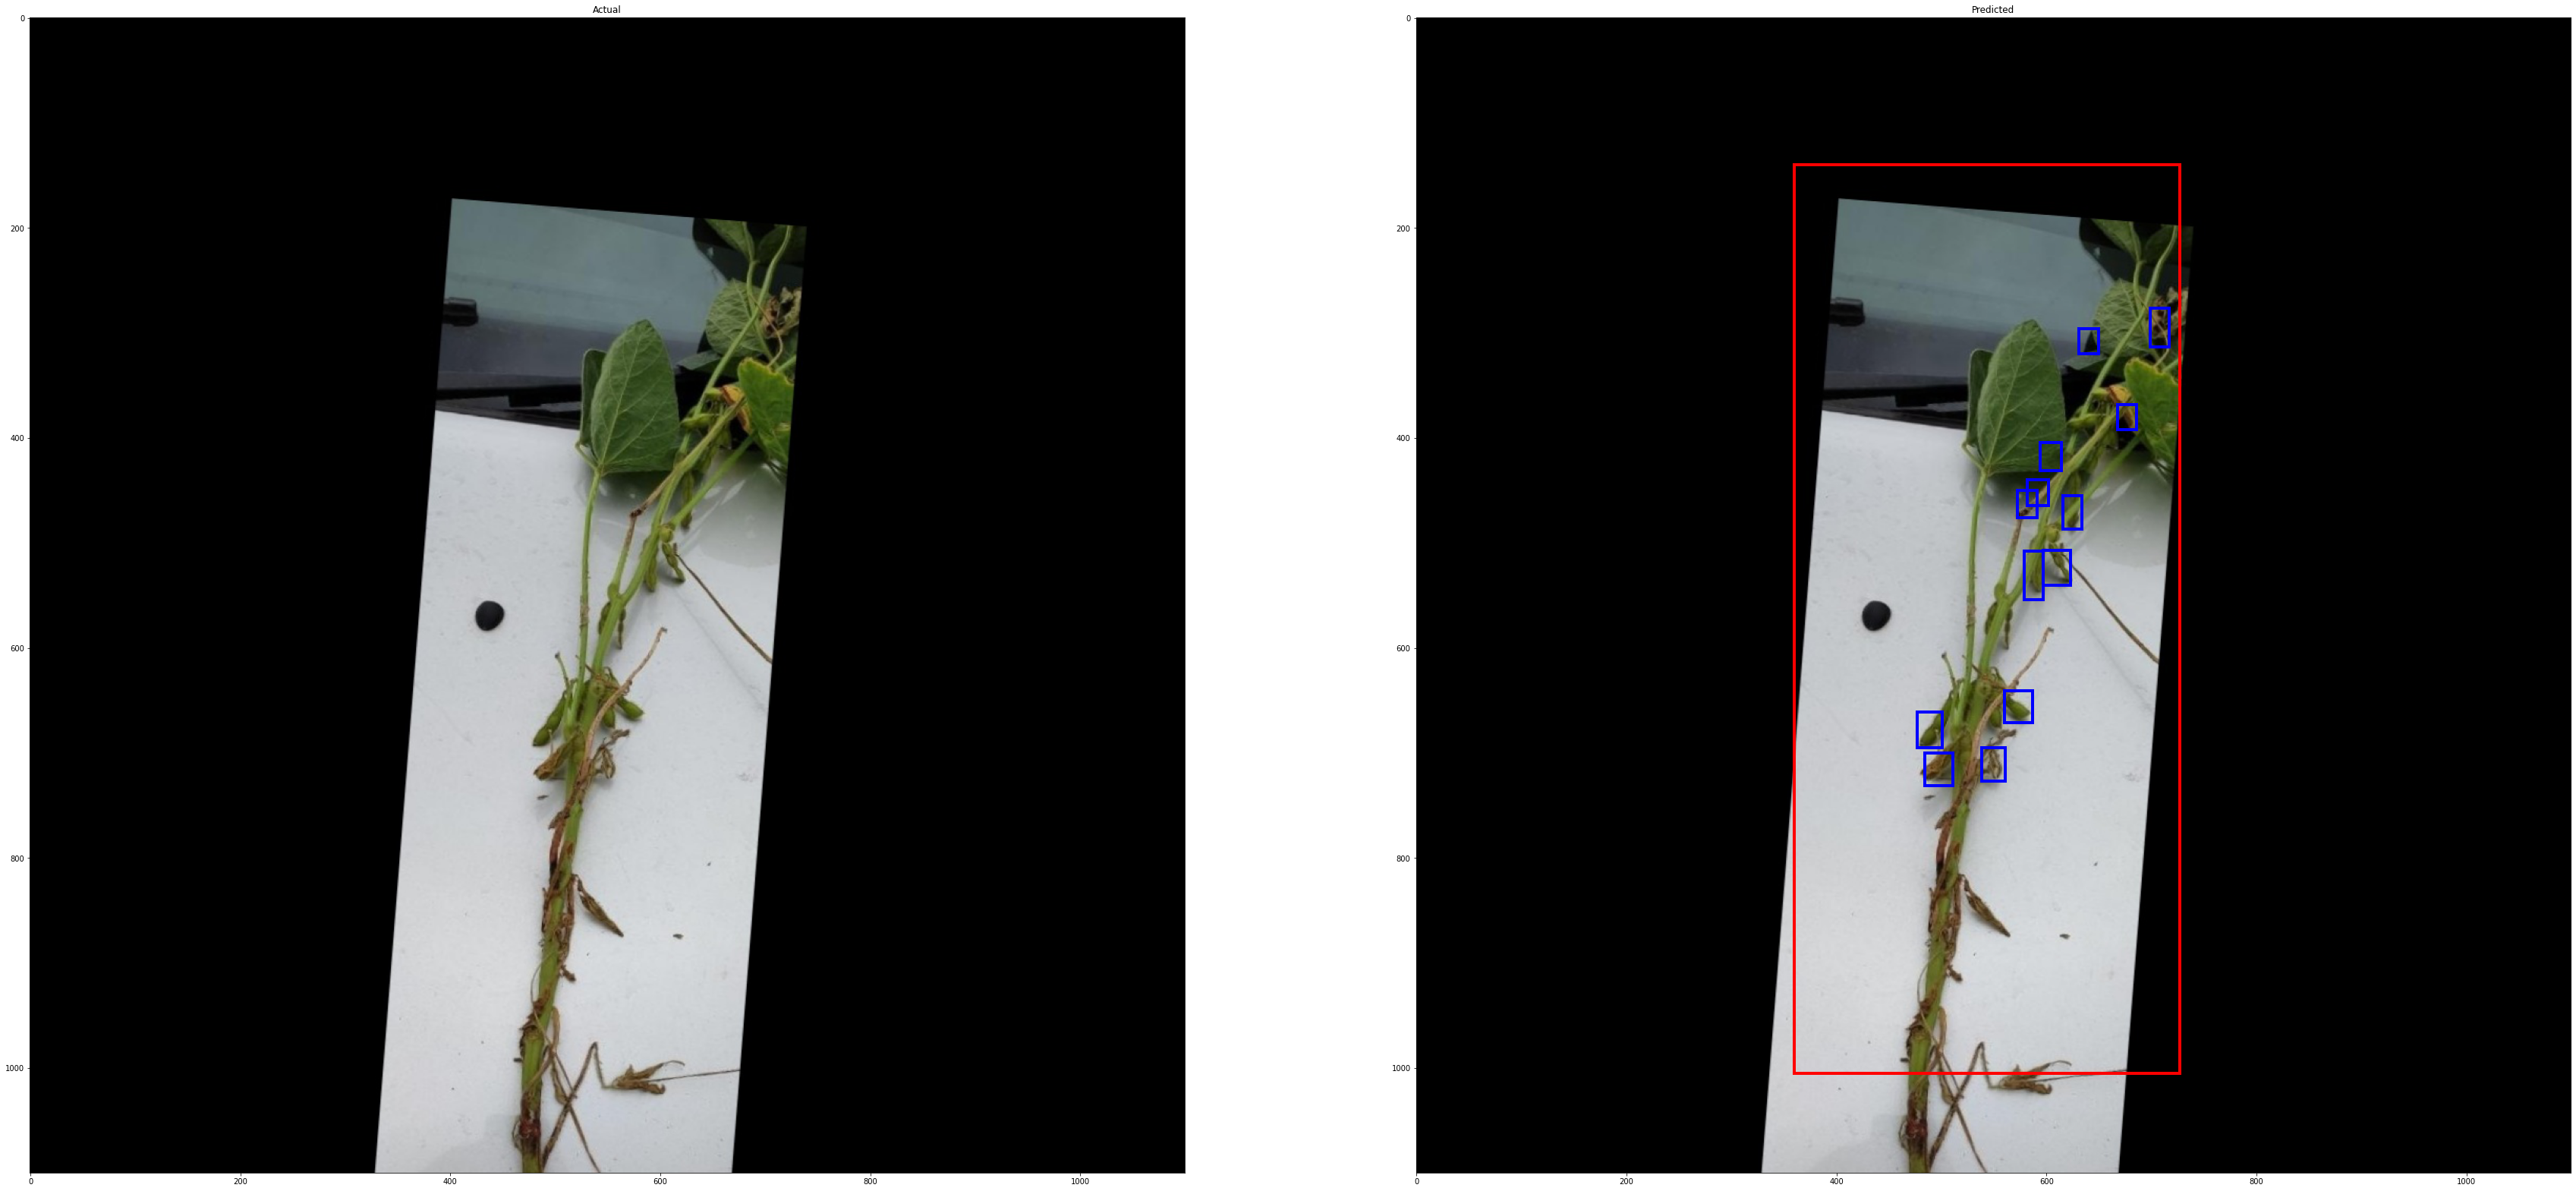

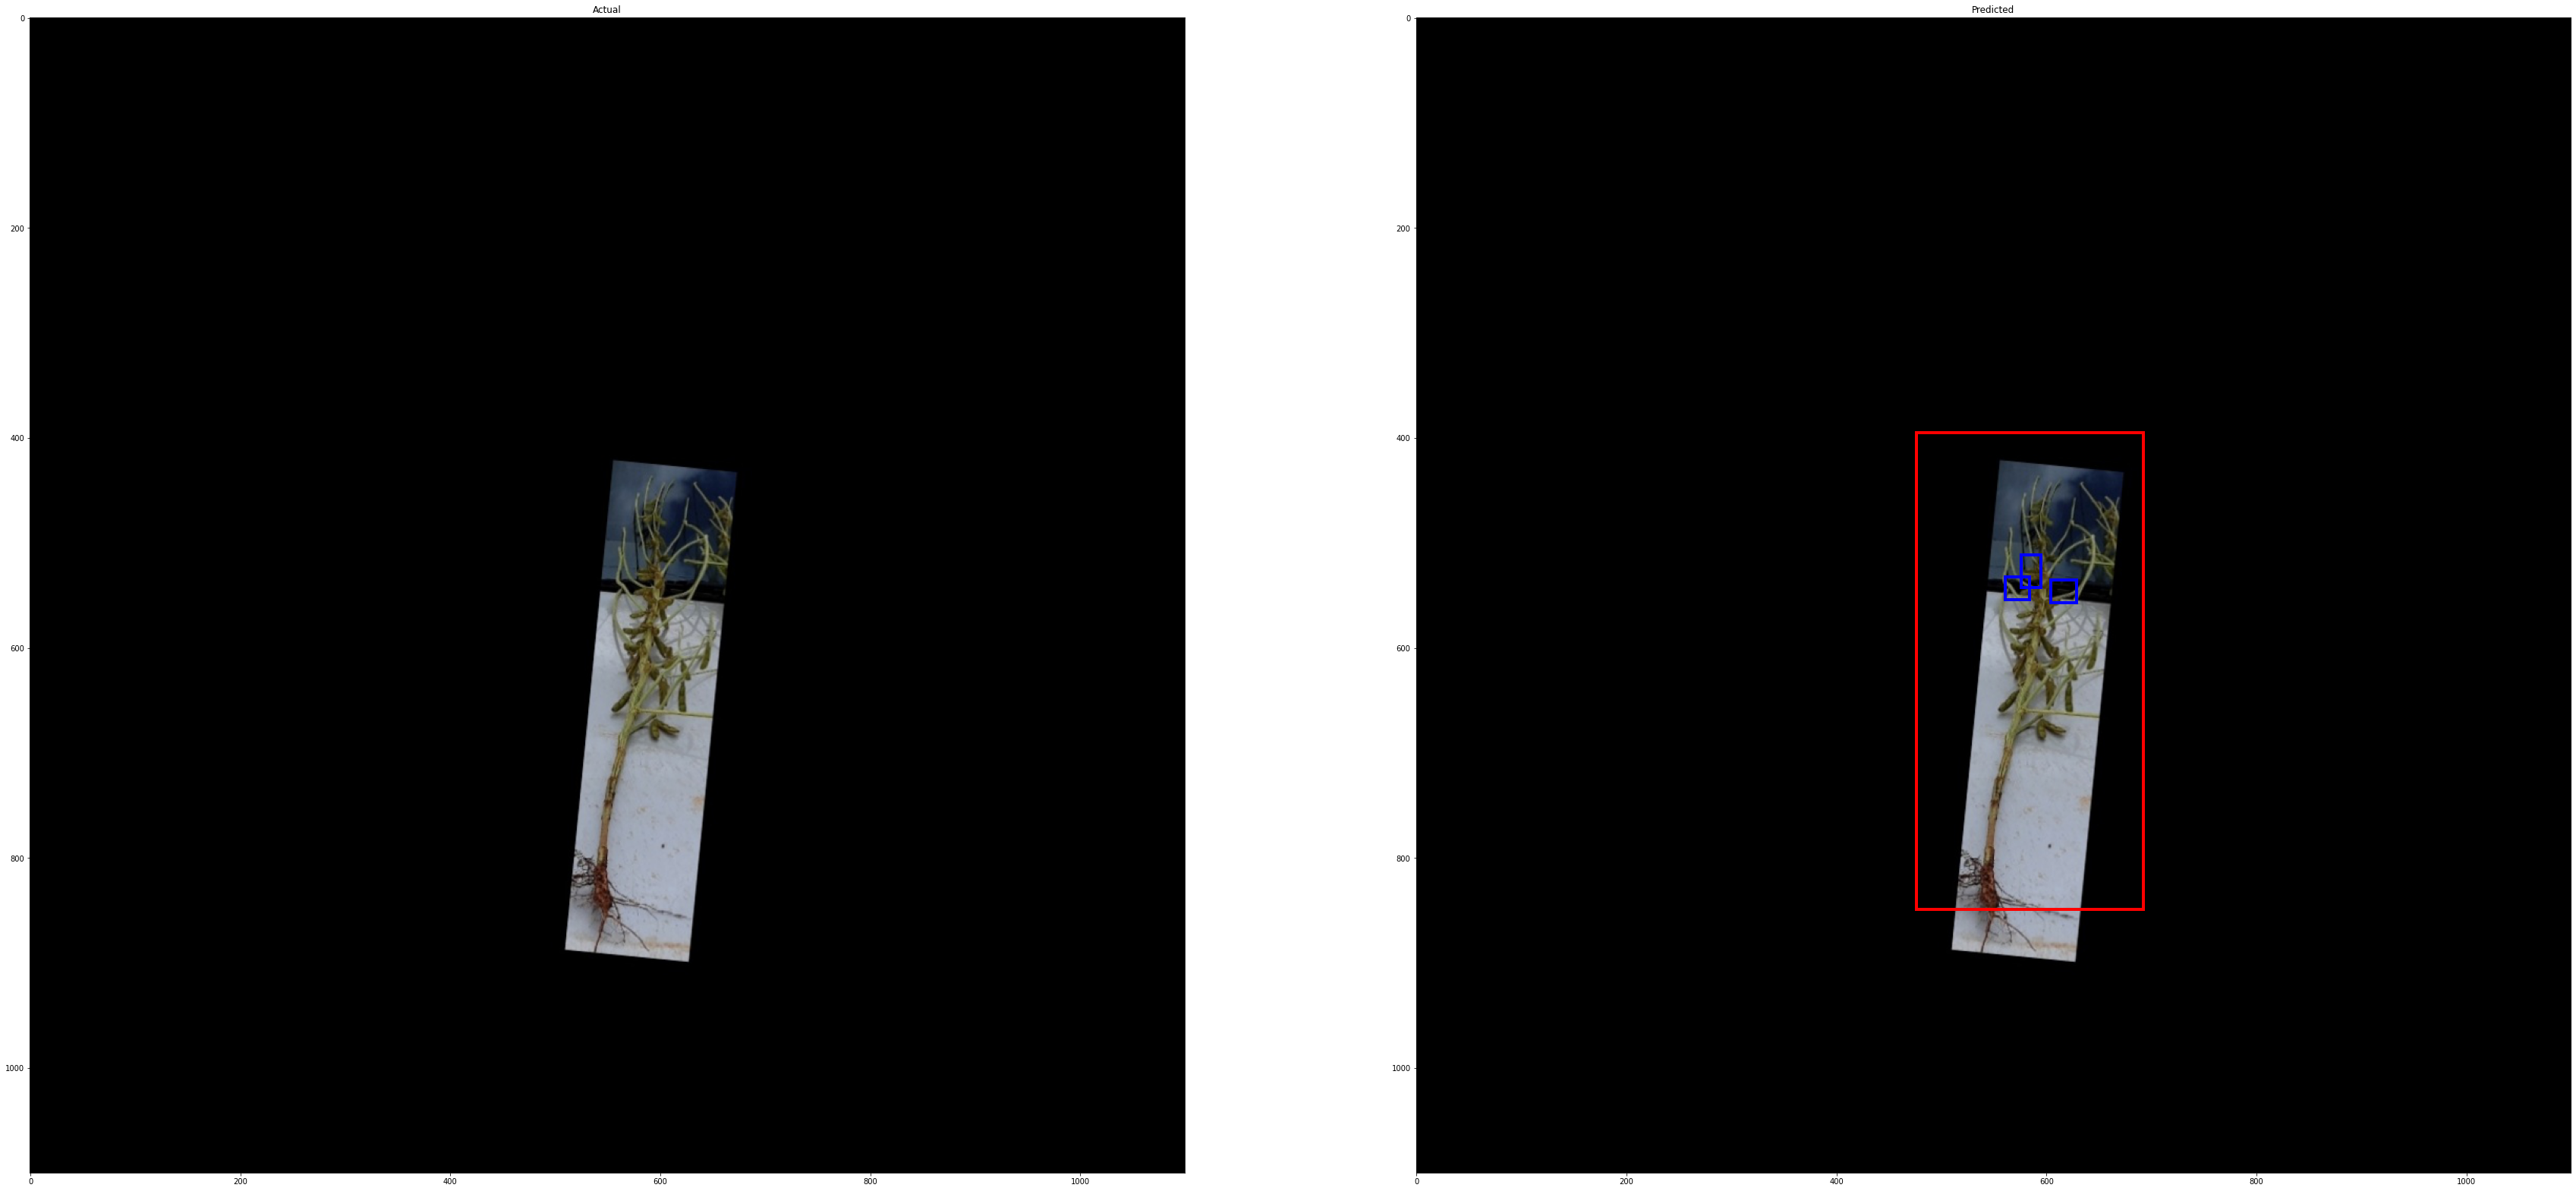

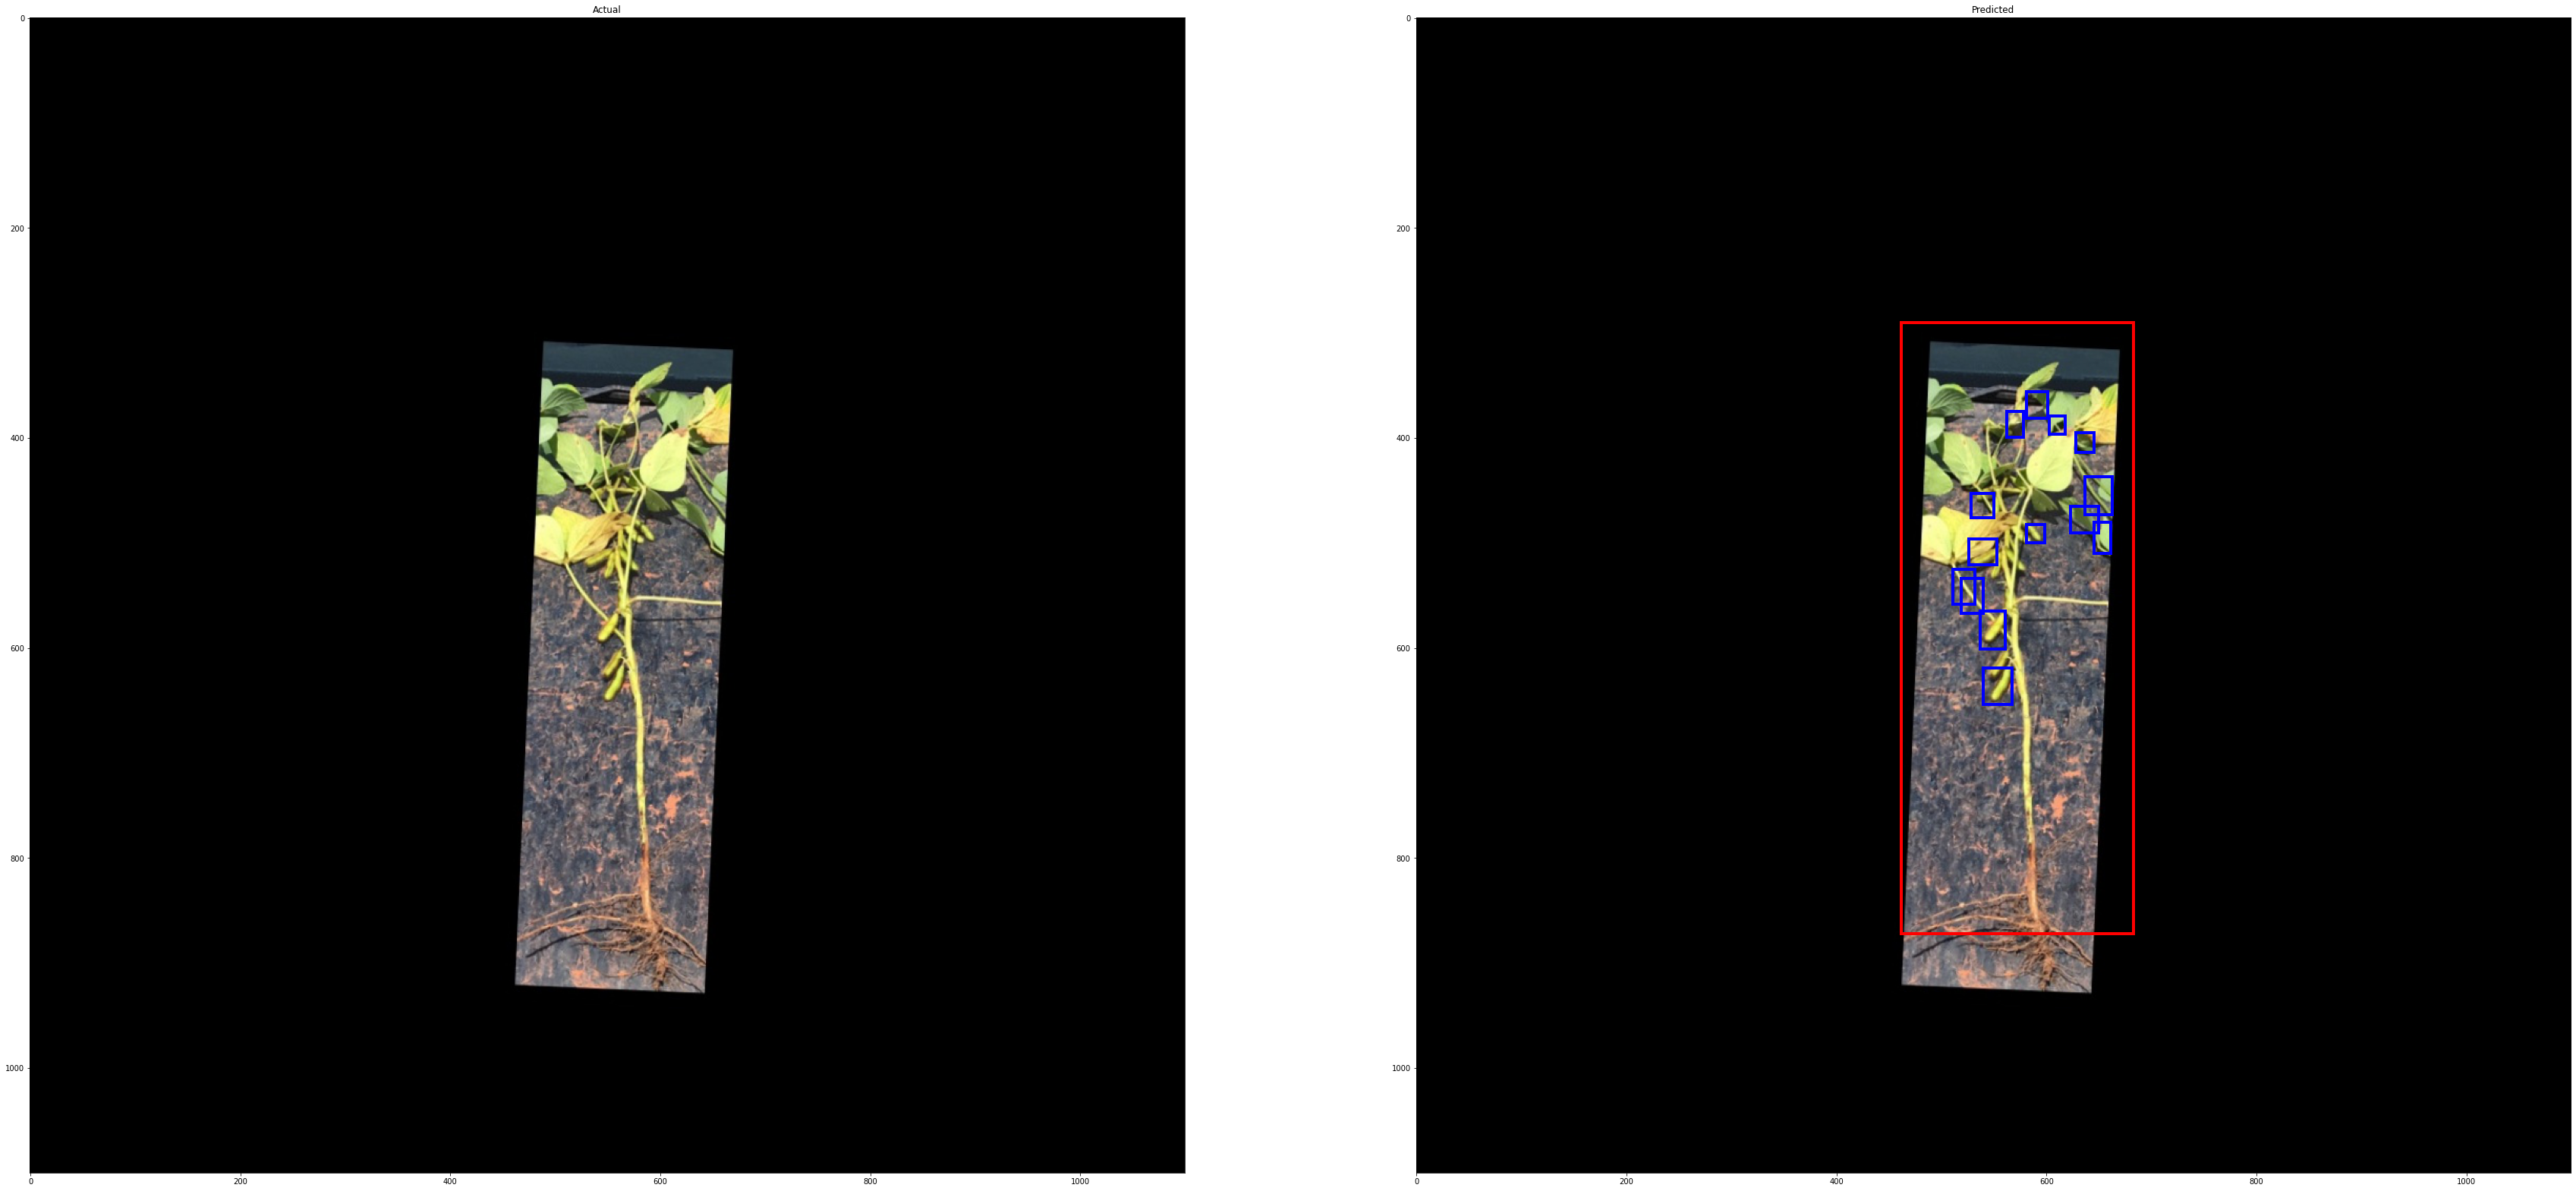

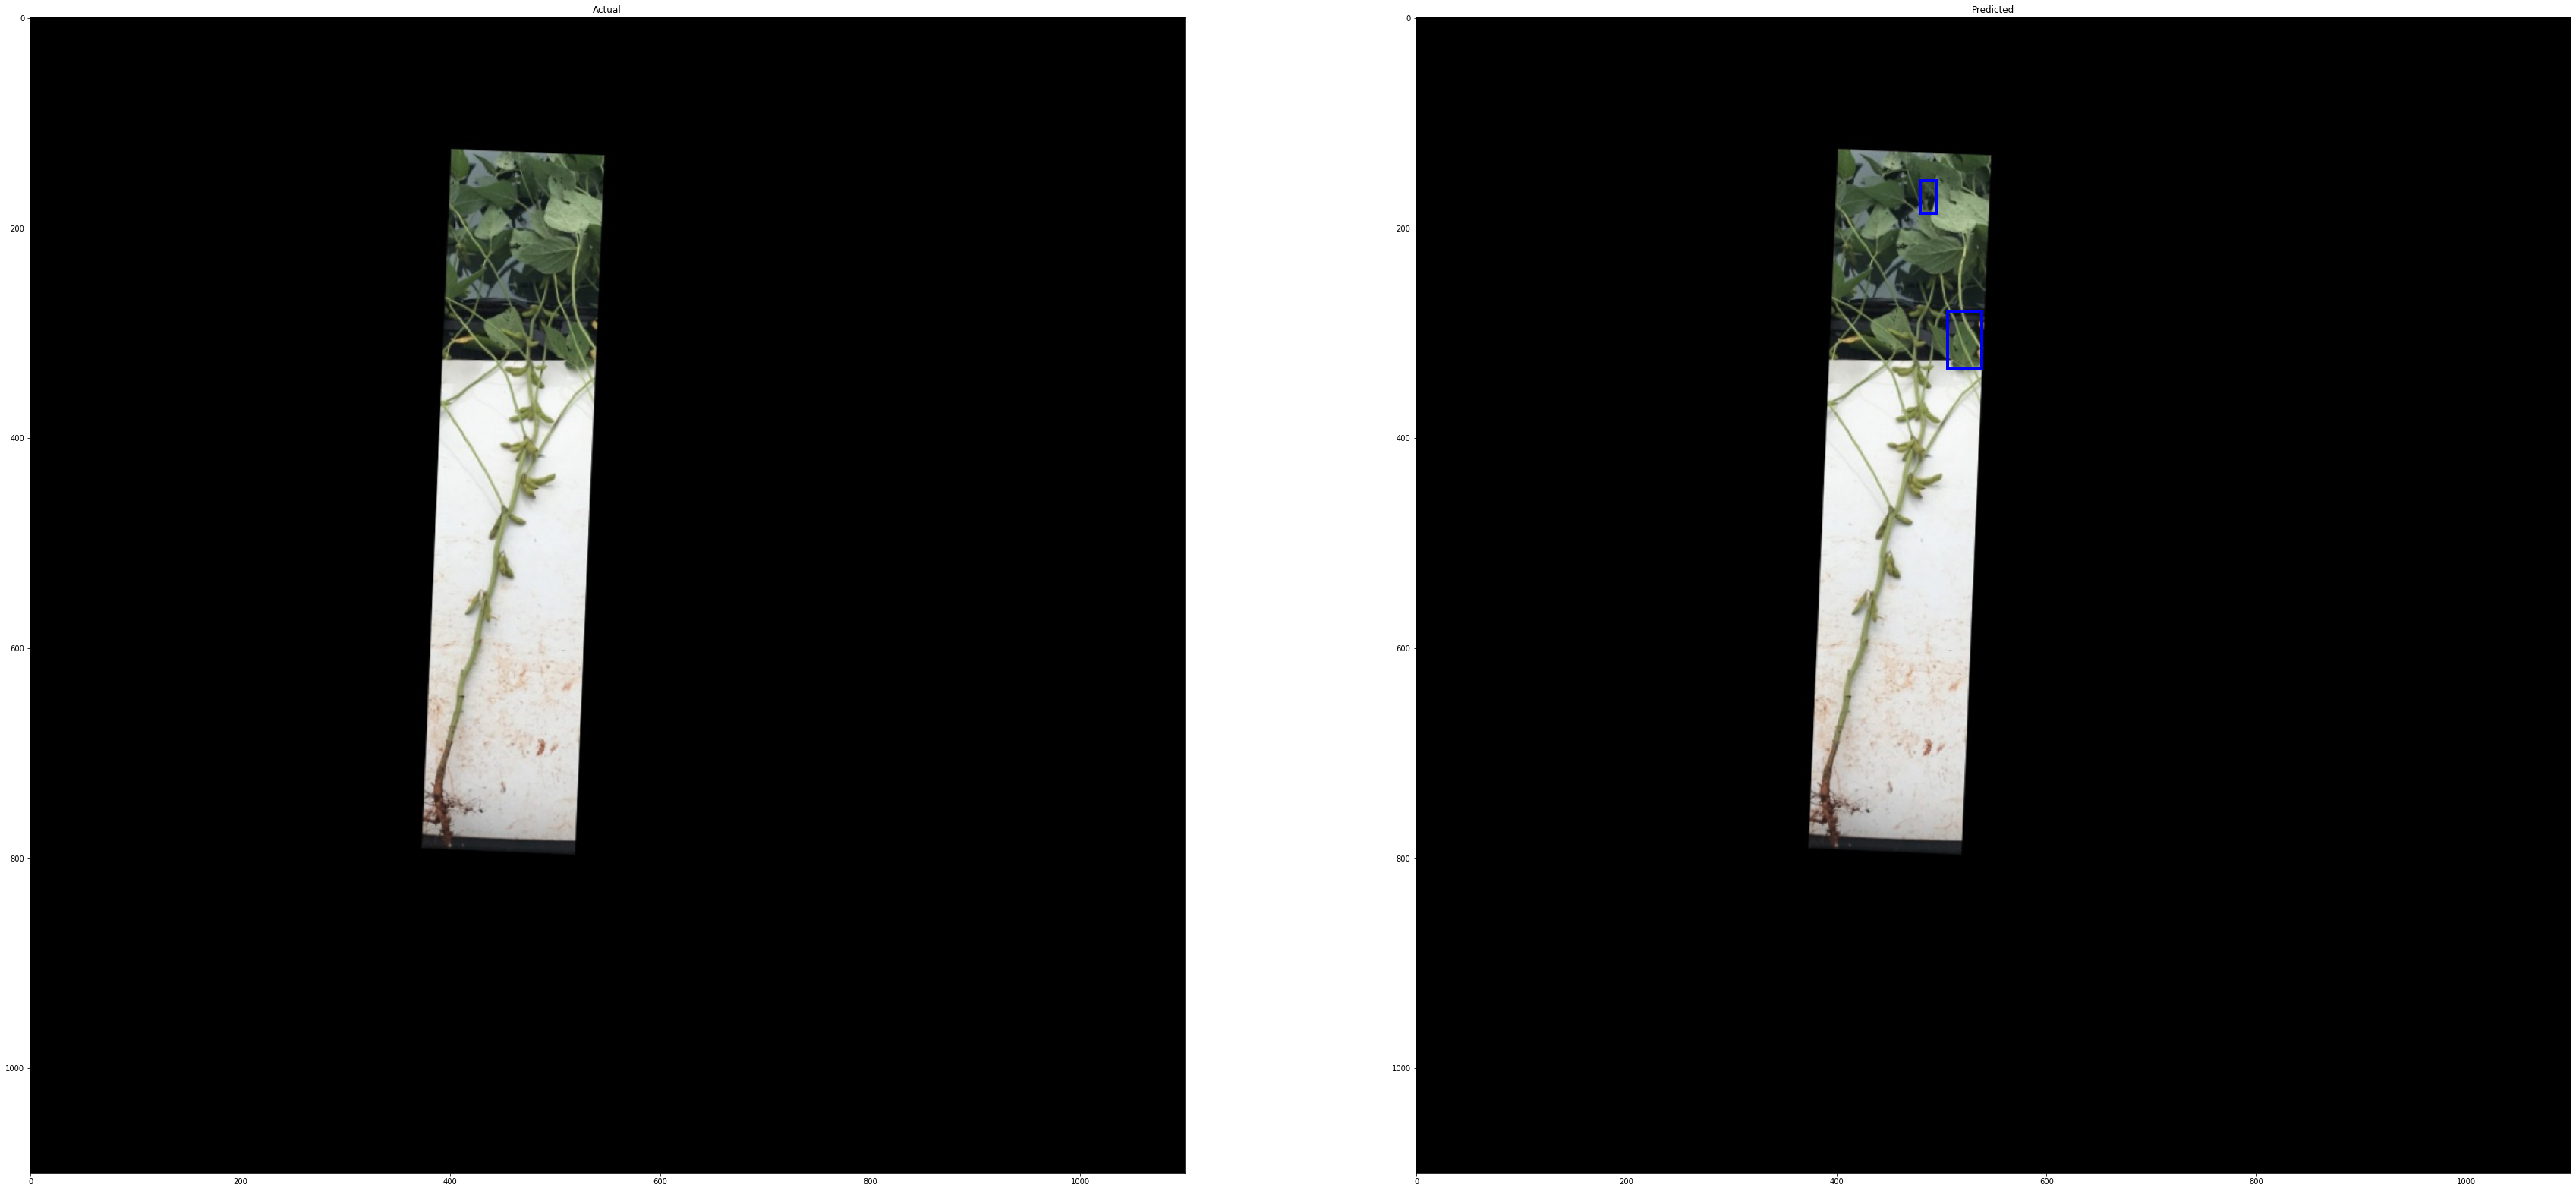

In [75]:
plot_actual_vs_predicted(train_set, model, prediction_config, "test_result.png")
plot_actual_vs_predicted(test_set, model, prediction_config, "val_result.png")

Zipping folder with the results

In [72]:
!zip -r /content/results.zip /content/results/

  adding: content/results/ (stored 0%)
  adding: content/results/16val_result.png (deflated 19%)
  adding: content/results/11test_result.png (deflated 16%)
  adding: content/results/7test_result.png (deflated 25%)
  adding: content/results/13val_result.png (deflated 15%)
  adding: content/results/31test_result.png (deflated 14%)
  adding: content/results/19val_result.png (deflated 24%)
  adding: content/results/18val_result.png (deflated 13%)
  adding: content/results/9val_result.png (deflated 20%)
  adding: content/results/24val_result.png (deflated 17%)
  adding: content/results/53test_result.png (deflated 11%)
  adding: content/results/10test_result.png (deflated 18%)
  adding: content/results/33test_result.png (deflated 13%)
  adding: content/results/12test_result.png (deflated 17%)
  adding: content/results/68test_result.png (deflated 11%)
  adding: content/results/8val_result.png (deflated 24%)
  adding: content/results/17val_result.png (deflated 17%)
  adding: content/results/28

Downloading zipped folder

In [73]:
from google.colab import files
files.download("/content/results.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>